# DQN + Rainbow
By Henry Frey, Vanessa Stöckl, Seif Saleh, Yi-Chieh Lin

RL lab homework DQN notebook used as base: Prof. Joschka Bödecker, Julien Brosseit

## 0 Setup
These are the same packages as in the last exercise:

In [97]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

In [98]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## 1 Deep Q-Networks
Remember, in Q-learning, we have the following update:

$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma \max_{a'}Q(s', a') - Q(s, a))$

with discount factor $\gamma$, learning rate $\alpha$, reward $r$, sampled state $s$, sampled next state $s'$ and sampled action $a$. Instead of a table, we will now use a neural network to represent the Q-function $Q(s, a; \theta)$, where $\theta$ are the parameters of the neural network. In order to learn the Q-function, we minimize the Mean Squared Error loss between our current estimate and our TD target using Stochastic gradient descent (SGD):

$ L(\theta) = \mathop{{}\mathbb{E}}_{(s, a, r, s') \sim D}([r + \gamma \max_{a'}Q(s', a'; \theta') - Q(s, a; \theta)]^2 )$  

where D is a dataset of sampled transitions and $\theta'$ are old parameters. This is very similar to how we train in a supervised learning setting!



## 1.1 Q-Network

Since we are representing our Q-function as a deep neural network, we will first define it using PyTorch. Then we will define the epsilon greedy policy and introduce how to decay the epsilon over time.

---


In the DQN paper, the network structure used is described as follows (although we have changed the hyperparameters!):
> The input to the neural network consists [..] [of] an 10 × 10 × n image [...]. The first hidden layer convolves 16 5 × 5
> filters with stride 1 with the input image and applies a rectifier nonlinearity. The second 
> hidden layer convolves 32 3 × 3 filters with stride 1, again followed by a rectifier nonlinearity. The
> final hidden layer is fully-connected and consists of 128 rectifier units. The output layer is a fully-
> connected linear layer with a single output for each valid action.

<span style="color:orange">**DQN**</span>

In [99]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.
        
        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """

        # obs_shape is the shape of a single observation -> use this information to define the dimensions of the layers
        super(DQN, self).__init__()

        # TODO: Your code here
        ### BEGIN SOLUTION
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)
        
        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()
        ### END SOLUTION


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: Your code here
        ### BEGIN SOLUTION
        x = x.permute(0, 3, 1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1) # flatten the intermediate result such that it can serve as input for the first linear layer

        # Final layer consists of 128 "rectifier" units meaning a ReLU activation
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out
        ### END SOLUTION


In [100]:
# Test

# Create dummy input
x_dummy = torch.randn(1, 10, 10, 4)
dqn = DQN(x_dummy.shape, 4)

assert dqn(x_dummy).shape == (1, 4), f"Expected output shape (1, 4) but got {dqn(x_dummy).shape}"
### BEGIN HIDDEN TESTS
# Check whether the network has two conv layers and two linear
assert len([m for m in dqn.modules() if isinstance(m, nn.Conv2d)]) == 2, "Expected 2 Conv2d layers"
assert len([m for m in dqn.modules() if isinstance(m, nn.Linear)]) == 2, "Expected 2 Linear layers"
### END HIDDEN TESTS


We import the epsilon greedy policy from our previous exercise. Note that we made some changes because Q is a network and epsilon is no longer fixed. 


<span style="color:orange">**Policy**</span>

In [101]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon. Taken from last exercise with changes.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)
        
        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [102]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    # TODO: Your code here
    ### BEGIN SOLUTION
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end
    ### END SOLUTION


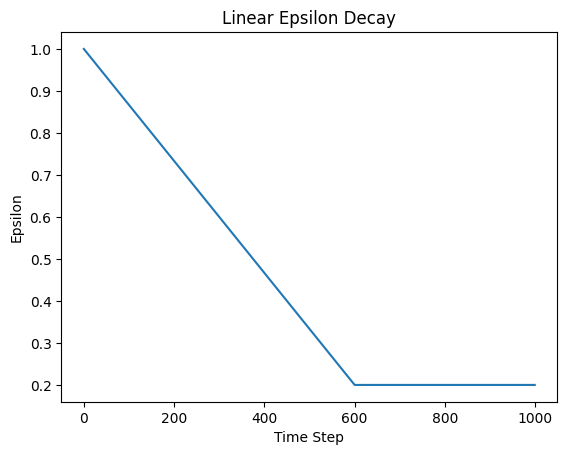

In [103]:
import matplotlib.pyplot as plt

eps_start = 1.0
eps_end = 0.2
schedule_duration = 1000

eps_values = [linear_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()
### BEGIN HIDDEN TESTS
assert eps_values[0] == eps_start, "Expected eps_values[0] to be eps_start"
assert eps_values[-1] == eps_end, "Expected eps_values[-1] to be eps_end"
assert len(eps_values) == schedule_duration, "Expected eps_values to have length schedule_duration"
assert np.abs(eps_values[300] - 0.6) < 1e-10, "Expected eps_values[600] to be 0.6"
assert eps_values[600] == 0.2, "Expected eps_values[600] to be 0.6"
### END HIDDEN TESTS


## 1.2 Target Network and Replay Buffer
As described before, the main idea behind DQN is simple, we just minimize the MSE between the TD-target and the current estimate using the transitions we sampled. However, there are two problems that make the method very unstable:

1. **Non-stationary target**: The TD-target uses an estimate from our Q-network. Unlike supervised learning, this target is not fixed, and whenever we update our network parameters, the target changes as well.
2. Sampled transitions are **correlated** (each transition depends on the last transition if both are from the same episode). Samples are not independent.

DQNs addresses both problems by using

1. **Target networks:**
An older set of network parameters is stored to compute the TD target, so they change less frequently and this improves stability. We call this network the target network. Its parameters are updated every few iterations.
2. **Experience Replay:**
A buffer where all transitions are stored and randomly sampled to make the data distribution more stationary. The buffer has a fixed size and new samples overwrite old ones.

First we look at the target network:

In [104]:
test_input = torch.tensor([1, 2, 3, 4], dtype=torch.float32)

# Given a neural network
net = nn.Sequential(
    nn.Linear(4, 3),
    nn.ReLU(), 
    nn.Linear(3, 1)
)
print(f"Prediction (Before): {net(test_input)}\n")

# We can get its parameters with .state_dict(). A dictionary containing all the parameters.
# Note: It contains even more than parameters, but that is not relevant for us.
params = copy.deepcopy(net.state_dict())

print("Parameters:")
for key, value in params.items():
    print(f"- Parameter {key}:\n{value}")

# Set weight matrix of first layer to zero
net[0].weight.data.fill_(0.0)
print(f"\nPrediction (After change): {net(test_input)}\n")

# Load the old parameters
net.load_state_dict(params)
print(f"Prediction (After reload): {net(test_input)}\n")


Prediction (Before): tensor([-0.3377], grad_fn=<ViewBackward0>)

Parameters:
- Parameter 0.weight:
tensor([[-0.2345,  0.4353, -0.3604,  0.2317],
        [ 0.1563,  0.0644, -0.4113,  0.4393],
        [-0.1002, -0.0327, -0.2466, -0.1194]])
- Parameter 0.bias:
tensor([-0.0495,  0.3060, -0.4552])
- Parameter 2.weight:
tensor([[ 0.0486, -0.0591, -0.1365]])
- Parameter 2.bias:
tensor([-0.2928])

Prediction (After change): tensor([-0.3109], grad_fn=<ViewBackward0>)

Prediction (After reload): tensor([-0.3377], grad_fn=<ViewBackward0>)



So we can save and load old parameters of our network using ``.state_dict()`` and ``.load_state_dict(..)`` respectively.

---
<span style="color:orange">**Replay Buffer**</span>

The replay buffer stores transitions of the form $(s, a, r, s')$ with $s$ as the current state, the action $a$, the reward $r$, and the next state $s'$. The buffer can perform two operations:
- **store**: During sampling we observe transitions and store them with ``buffer.store(...)``. However, the buffer only has a fixed size
(as we cannot store an infinte amount of data). When reaching it, the oldest samples are overwritten first.
- **sample**: For training, we want to sample a batch of transitions from our buffer via ``buffer.sample(...)``. The transitions are sampled uniformly and with replacement i.e. the same transition can be sampled more than once.



In [105]:
class NStepReplayBuffer:
    def __init__(self, max_size: int, n_step: int = 3, gamma: float = 0.99):
        """
        Create the n-step replay buffer.

        :param max_size: Maximum number of transitions in the buffer
        :param n_step: Number of steps to accumulate rewards over
        :param gamma: Discount factor
        """
        """
        Create the n-step replay buffer.

        :param max_size: Maximum number of transitions in the buffer
        :param n_step: Number of steps to accumulate rewards over
        :param gamma: Discount factor
        """
        self.data = []
        self.max_size = max_size
        self.position = 0
        self.n_step = n_step
        self.gamma = gamma
        
        # Buffer for building n-step transitions
        self.temp_buffer = []

    def _get_n_step_info(self):
        """Calculate n-step reward and next state"""
        # Get the first (oldest) transition
        first = self.temp_buffer[0]
        
        # Calculate n-step reward
        n_step_reward = 0
        for i in range(self.n_step):
            if i >= len(self.temp_buffer):
                break
            n_step_reward += (self.gamma ** i) * self.temp_buffer[i][2]  # index 2 is reward
            
            # If episode terminated, don't include future rewards
            if self.temp_buffer[i][4]:  # index 4 is terminated flag
                break
        
        # Get the n-th next state and done flag
        if len(self.temp_buffer) >= self.n_step:
            next_state = self.temp_buffer[self.n_step - 1][3]  # index 3 is next_state
            done = self.temp_buffer[self.n_step - 1][4]
        else:
            next_state = self.temp_buffer[-1][3]
            done = self.temp_buffer[-1][4]
            
        return n_step_reward, next_state, done

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, 
              next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer.
        
        :param obs: The current observation
        :param action: The action
        :param reward: The reward
        :param next_obs: The next observation
        :param terminated: Whether the episode terminated
        """
        # Add transition to temporary buffer
        self.temp_buffer.append((obs, action, reward, next_obs, terminated))
        
        # If we have enough transitions, compute n-step transition
        if len(self.temp_buffer) >= self.n_step:
            n_step_reward, next_state, done = self._get_n_step_info()
            first_transition = self.temp_buffer[0]
            
            # Store the n-step transition
            transition = (
                first_transition[0],  # observation
                first_transition[1],  # action
                n_step_reward,        # n-step cumulative reward
                next_state,           # n-step next state
                done                  # done flag
            )
            
            if len(self.data) < self.max_size:
                self.data.append(transition)
            else:
                self.data[self.position] = transition
            
            self.position = (self.position + 1) % self.max_size
            
            # Remove the oldest transition
            self.temp_buffer.pop(0)
        
        # Clear temp buffer if episode terminated
        if terminated:
            while len(self.temp_buffer) > 0:
                n_step_reward, next_state, done = self._get_n_step_info()
                first_transition = self.temp_buffer[0]
                
                transition = (
                    first_transition[0],
                    first_transition[1],
                    n_step_reward,
                    next_state,
                    done
                )
                
                if len(self.data) < self.max_size:
                    self.data.append(transition)
                else:
                    self.data[self.position] = transition
                self.position = (self.position + 1) % self.max_size
                
                self.temp_buffer.pop(0)

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of n-step transitions.
        
        :param batch_size: The batch size
        :returns: Tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch)
        """
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]



<span style="color:orange">**Prioritized Experience Replay**</span>

In [106]:
class PrioritizedExperienceReplay(NStepReplayBuffer):
    def __init__(self, max_size: int, n_step: int = 3, gamma: float = 0.99, alpha: float = 0.6, beta: float = 0.4, eps: float = 1e-6):
        self.max_size = max_size
        self.n_step = n_step
        self.gamma = gamma
        self.alpha = alpha
        self.beta = beta
        self.eps = eps
        self.priorities = np.zeros(max_size)
        self.data = []
        self.pos = 0
        self.temp_buffer = []

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, 
              next_obs: torch.Tensor, terminated: torch.Tensor):
        transition = (obs, action, reward, next_obs, terminated)
        if len(self.data) < self.max_size:
            self.data.append(transition)
        else:
            self.data[self.pos] = transition
            
        max_prio = self.priorities.max() if self.priorities.max() > 0 else 1.0
        self.priorities[self.pos] = max_prio
        self.pos = (self.pos + 1) % self.max_size

    def sample(self, batch_size: int):
        if len(self.data) == self.max_size:
            prios = self.priorities
        else:
            prios = self.priorities[:len(self.data)]
            
        probs = (prios + self.eps) ** self.alpha
        probs /= probs.sum()
        
        indices = np.random.choice(len(self.data), batch_size, p=probs)
        weights = (len(self.data) * probs[indices]) ** (-self.beta)
        weights /= weights.max()
        
        samples = [self.data[idx] for idx in indices]
        batch = [torch.stack(b) for b in zip(*samples)]
        batch.append(torch.tensor(indices))
        batch.append(torch.tensor(weights, dtype=torch.float32))
        
        return batch

    def update(self, priorities: list, indices: list):
        for idx, prio in zip(indices, priorities):
            self.priorities[idx] = abs(prio) + self.eps

    def __len__(self):
        return len(self.data)

## 1.3 Algorithm
In this section, we will first look at the update of the DQN and then implement the entire algorithm.

---
<span style="color:orange">**DQN Update**</span>


In [107]:
def update_dqn_nstep(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        n_step: int,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        weights: torch.Tensor = None,
    ):
    optimizer.zero_grad()

    with torch.no_grad():
        next_action = q(next_obs).argmax(dim=1)
        next_q_values = q_target(next_obs)
        next_q_value = next_q_values.gather(1, next_action.unsqueeze(1)).squeeze(1)
        td_target = rew + (gamma ** n_step) * next_q_value * (1 - tm.float())

    current_q_values = q(obs)
    current_q_value = current_q_values.gather(1, act.unsqueeze(1))

    td_error = (current_q_value - td_target.unsqueeze(1)).abs()
    
    if weights is not None:
        loss = (weights.unsqueeze(1) * td_error ** 2).mean()
    else:
        loss = td_error.pow(2).mean()

    loss.backward()
    optimizer.step()

    return td_error.squeeze(), current_q_values

We are now putting it all together. This implementation is very similar to the Q-learning one. Note that we have not specified an environment yet! Our algorithm remains relatively flexible.

---
<span style="color:orange">**DQN Agent**</span>


In [108]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001, 
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            n_step=3,
        ):
        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.n_step = n_step

        self.buffer = PrioritizedExperienceReplay(maxlen, n_step=n_step, gamma=gamma)
        self.q = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)
        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

    def train(self, num_episodes: int, min_buffer_size: int = 1000) -> EpisodeStats:
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            if (i_episode + 1) % 50 == 0:
                avg_td_error = np.mean([abs(td) for td in td_errors.detach().numpy()])
                max_q_val = torch.max(q_values).item()
                print(f'Episode {i_episode + 1}/{num_episodes}')
                print(f'Avg reward: {np.mean(stats.episode_rewards[max(0, i_episode-99):i_episode+1]):.2f}')
                print(f'Avg TD error: {avg_td_error:.4f}')
                print(f'Max Q-value: {max_q_val:.4f}')
                print(f'Priority stats: min={self.buffer.priorities.min():.4f}, max={self.buffer.priorities.max():.4f}')
                print('-------------------')
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            obs, _ = self.env.reset()
            
            for episode_time in itertools.count():
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )
                # Add inside train() method, where stats are printed:

                if len(self.buffer) > min_buffer_size:
                    obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch, ids, weights = self.buffer.sample(self.batch_size)
                    
                    td_errors, q_values  = update_dqn_nstep(
                        self.q,
                        self.q_target,
                        self.optimizer,
                        self.gamma,
                        self.n_step,
                        obs_batch.float(),
                        act_batch,
                        rew_batch.float(),
                        next_obs_batch.float(),
                        tm_batch,
                        weights
                    )
                    
                    self.buffer.update(td_errors.detach().numpy(), ids.tolist())

                    if current_timestep % self.update_freq == 0:
                        self.q_target.load_state_dict(self.q.state_dict())
                
                current_timestep += 1

                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
                
        return stats

## 1.4 Training
Now, we want to run our algorithm on a task in [MinAtar](https://github.com/kenjyoung/MinAtar) with the use of SpaceInvaders-v1. 

The player controls a cannon at the bottom of the screen and can shoot bullets upward at a cluster of aliens above. The aliens move across the screen until one of them hits the edge, at which point they all move down and switch directions. The current alien direction is indicated by 2 channels (one for left and one for right) one of which is active at the location of each alien. A reward of +1 is given each time an alien is shot, and that alien is also removed. The aliens will also shoot bullets back at the player. When few aliens are left, alien speed will begin to increase. When only one alien is left, it will move at one cell per frame. When a wave of aliens is fully cleared, a new one will spawn which moves at a slightly faster speed than the last. Termination occurs when an alien or bullet hits the player.

based on [MinAtar](https://github.com/kenjyoung/MinAtar) 

In [109]:
from gymnasium.wrappers import FrameStack, GrayScaleObservation, ResizeObservation

# Choose your environment
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters, Hint: Change as you see fit
LR = 0.00025
BATCH_SIZE = 32
REPLAY_BUFFER_SIZE = 100_000
UPDATE_FREQ = 200
EPS_START = 1.0
EPS_END = 0.1
SCHEDULE_DURATION = 50_000
NUM_EPISODES = 1000
DISCOUNT_FACTOR = 0.99

# Train DQN
agent = DQNAgent(
    env, 
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)

Episode 50/1000
Avg reward: 4.18
Avg TD error: 0.1877
Max Q-value: 2.8674
Priority stats: min=0.0000, max=1.5691
-------------------
Episode 100/1000
Avg reward: 4.30
Avg TD error: 0.4315
Max Q-value: 5.3593
Priority stats: min=0.0000, max=3.8869
-------------------
Episode 100 of 1000  Time Step: 5631  Epsilon: 0.899
Episode 150/1000
Avg reward: 4.90
Avg TD error: 0.4109
Max Q-value: 7.2708
Priority stats: min=0.0000, max=5.6776
-------------------
Episode 200/1000
Avg reward: 5.94
Avg TD error: 0.3259
Max Q-value: 8.9217
Priority stats: min=0.0000, max=8.0194
-------------------
Episode 200 of 1000  Time Step: 12290  Epsilon: 0.779
Episode 250/1000
Avg reward: 6.26
Avg TD error: 0.3858
Max Q-value: 9.9877
Priority stats: min=0.0000, max=8.0194
-------------------
Episode 300/1000
Avg reward: 7.05
Avg TD error: 0.3873
Max Q-value: 9.0136
Priority stats: min=0.0000, ma

# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

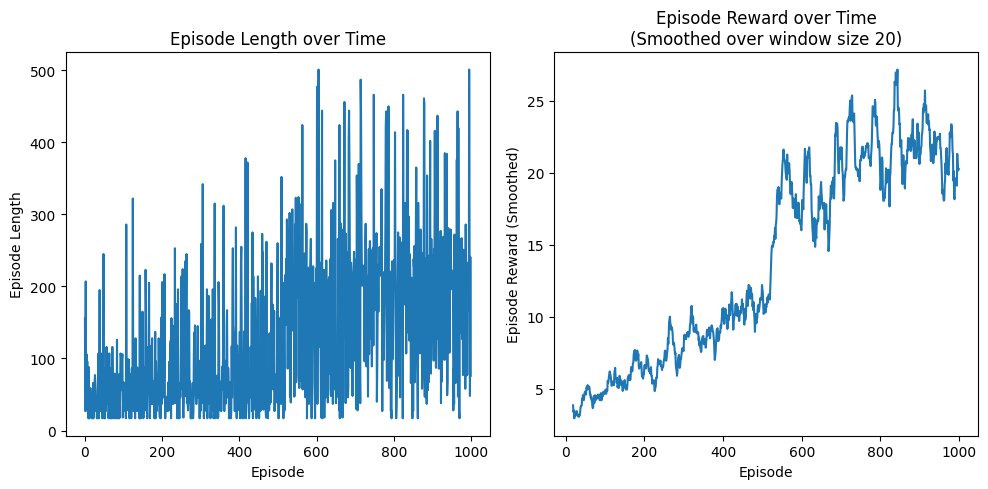

In [110]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time") 

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

Lastly, let us see what the learned policy does in action.

c:\Users\Akademiker\miniconda3\envs\rl_lab\lib\site-packages\gymnasium\utils\passive_env_checker.py:335: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
c:\Users\Akademiker\miniconda3\envs\rl_lab\lib\site-packages\gymnasium\utils\passive_env_checker.py:276: UserWarning: WARN: RGB-array rendering should return a numpy array with dtype uint8, got float64
  logger.warn(


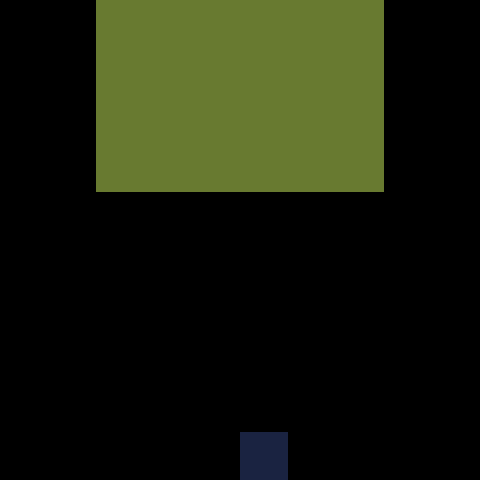

In [111]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=100):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")